<a href="https://colab.research.google.com/github/IsaacFigNewton/Cyclic-Decision-Graph-Generator/blob/main/KNN_Estimation_of_Feature_Probability_Distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Config

In [1]:
import numpy as np
from collections import defaultdict
import pandas as pd
import json
import seaborn as sns
from itertools import permutations, product
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y,\
                                      check_is_fitted,\
                                      check_array
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer,\
                                      KBinsDiscretizer,\
                                      OneHotEncoder,\
                                      StandardScaler
from sklearn.neighbors import KernelDensity,\
                                      KNeighborsRegressor,\
                                      KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,\
                                      MultinomialNB
from sklearn.svm import SVC as SVM
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score,\
                                      recall_score,\
                                      accuracy_score,\
                                      f1_score,\
                                      make_scorer
from sklearn.model_selection import KFold,\
                                      GridSearchCV,\
                                      cross_val_score,\
                                      cross_validate

In [2]:
# Prepare for k-fold cross-validation
default_n_neighbors = 1
max_bins_for_discretization = None
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
colormap = {
    0: 'red',
    1: 'green'
}
class_map = dict()

# Lists to store evaluation metrics
precisions, recalls, accuracies, f1_scores = [], [], [], []

# Important Functions

## Probability Mass Function Estimator Class

In [3]:
class PMFRegressor(ClassifierMixin, BaseEstimator):

    def __init__(self, max_bins=None, alpha=1e-9, n_neighbors=1):
        # Max bins for discretization, to limit memory usage
        self.max_bins = max_bins
        # minimum weighted probability (0 implies that the feature of datapoints belonging to a class never takes on a given value)
        self.alpha = alpha
        #Number of neighbors to use in KNN estimation
        self.n_neighbors = n_neighbors
        self.classes_ = None
        self.X = None
        self.y = None
        self.prior_class_probabilities = None
        self.feature_distribution = None
        self.pmf_store = None


    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X = X
        self.y = y
        self.classes_ = np.unique(y)

        print("X:")
        print(X[:5])
        print("y:")
        print(y[:5])

        # Estimate the probability mass function
        self.prior_class_probabilities, self.feature_distribution, self.pmf_store = self.get_prob_distribution()

        # Return the classifier
        return self


    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        y = np.empty(X.shape[0], dtype=self.classes_.dtype)

        for i in range(X.shape[0]):
            datapoint = {j: X[i, j] for j in range(X.shape[1])}
            class_probabilities = self.calculate_class_probabilities(datapoint)
            predicted_class = max(class_probabilities, key=class_probabilities.get)
            y[i] = predicted_class

        return y



    # Main functions
    #*******************************************************************************************************************************************

    def get_prob_distribution(self):
        prior_class_probabilities = {class_value: self.get_prior_probability(class_value) for class_value in self.classes_}
        # create a multilevel dict to represent the weighted probabilities of every unique value of every feature for every class
        feature_distribution = {class_value: {feature: {} for feature in range(self.X.shape[1])} for class_value in self.classes_}
        # create a dict to hold the global probabilities of every unique value in every feature
        global_unique_val_probabilities = {feature: {} for feature in range(self.X.shape[1])}
        # create a dict to store PMFs for each feature and unique value
        pmf_store = {class_value: {feature: defaultdict() for feature in range(self.X.shape[1])} for class_value in self.classes_}


        # Calculating and storing PMFs
        for feature in range(self.X.shape[1]):
            # Get unique values for the current feature
            # default; discretize down to scale of datapoints
            unique_values = np.unique(self.X[:, feature])

            # alternate; discretize down to datapoints or max_bins
            if self.max_bins is not None and len(unique_values) > self.max_bins:
                 discretizer = KBinsDiscretizer(n_bins=self.max_bins, encode='ordinal', strategy='quantile')
                 unique_values = discretizer.fit_transform(unique_values.reshape(-1, 1)).flatten()


            # Calculate the weighted probability for each unique value
            for unique_value in unique_values:
                # Calculate the probability distribution for the current feature and unique value
                prob_distribution, p_unique = self.calculate_weighted_prob(unique_value, feature)

                # Add the weighted probabilities of the unique value to the feature distribution set
                for class_value in self.classes_:
                    feature_distribution[class_value][feature][unique_value] = prob_distribution[class_value]

                    # Create a KNN for the current feature
                    pmf = self.create_pmf_using_knn(class_value, feature, feature_distribution)

                    # Store the KNN for the current feature and class
                    pmf_store[class_value][feature] = pmf

                # Store the probability distribution for the current feature and unique value
                global_unique_val_probabilities[feature][unique_value] = p_unique

        return prior_class_probabilities, feature_distribution, pmf_store


    # Function to get prior probability of the class
    def get_prior_probability(self, class_value):
        return np.sum(self.y == class_value) / len(self.X)


    # Function to calculate probability distribution
    def calculate_weighted_prob(self, unique_value, feature):
        weighted_prob = {}

        # Calculate the probability of the unique value in the dataset as a whole
        mask = self.X[:, feature] == unique_value
        p_unique = np.sum(mask) / len(self.X)

        for class_value in self.classes_:
            # Filter the dataset for the current class and feature value
            class_mask = self.y == class_value
            class_data_mask = mask & class_mask

            p_unique_given_class = np.sum(class_data_mask) / np.sum(class_mask)

            # Avoid division by zero
            if p_unique > 0:
                weighted_prob[class_value] = p_unique_given_class / p_unique
            else:
                # No data for this unique value
                weighted_prob[class_value] = self.alpha

        return weighted_prob, p_unique


    # Function to create PMF using KNN
    def create_pmf_using_knn(self, class_value, feature, prob_distribution):
        # Get the values for the current feature and class
        values = np.array(list(prob_distribution[class_value][feature].keys())).reshape(-1, 1)
        # Get the weighted probabilities for the current feature and class
        probabilities = np.array(list(prob_distribution[class_value][feature].values()))

        # Create a kernel density estimator using Gaussian kernel
        knn = KNeighborsRegressor(n_neighbors=self.n_neighbors).fit(values, probabilities)

        return knn


    # Function to calculate P(class | feature1_value /\ feature2_value /\ …)
    def calculate_class_probabilities(self, feature_values):
        class_probabilities = {class_value: 1 for class_value in self.prior_class_probabilities.keys()}

        for class_value in self.prior_class_probabilities.keys():
            likelihood = 1
            for feature, value in feature_values.items():
                feature_likelihood = self.pmf_store[class_value][feature].predict(np.array([[value]]))
                # Accumulate features' weighted probabilities
                likelihood *= feature_likelihood

            # Get final class probability
            class_probability = likelihood * self.prior_class_probabilities[class_value]
            class_probabilities[class_value] = class_probability

        return class_probabilities



    # Helper functions
    #*******************************************************************************************************************************************

    # Map the features' weighted probability distributions to lists of features' values and their weighted probabilities
    def feature_distribution_to_dict(self):
        return {
            class_value: {
                feature: (list(self.feature_distribution[class_value][feature].keys()),
                          list(self.feature_distribution[class_value][feature].values()))
                for feature in range(self.X.shape[1])
            } for class_value in self.classes_
        }


    def print_weighted_prob_dist(self):
        print("Feature Distribution:")
        print(self.feature_distribution_to_dict())

## Utility

In [4]:
# Custom transformer to convert sparse matrix to dense
def to_dense(X):
    return np.array(X.todense()) if hasattr(X, 'todense') else X

dense_transformer = FunctionTransformer(to_dense)

In [5]:
def print_tree(tree, indent=0):
    # Iterate over the keys (features) in the tree
    for key, value in tree.items():
        print(' ' * indent + str(key))
        # If the value is a dictionary, recursively print the subtree
        if isinstance(value, dict):
            print_tree(value, indent + 4)
        else:
            print(' ' * (indent + 4) + str(value))

In [6]:
def cv_results_to_dict(pipeline, X, y):
    model_name = pipeline.steps[-1][0]

    # Perform cross-validation
    cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring, return_train_score=False)

    # Calculate average scores and standard deviations
    avg_scores[model_name] = {
            "precision": cv_results['test_precision'].mean(),
            "recall": cv_results['test_recall'].mean(),
            "accuracy": cv_results['test_accuracy'].mean(),
            "f1": cv_results['test_f1'].mean(),
            "std_precision": cv_results['test_precision'].std(),
            "std_recall": cv_results['test_recall'].std(),
            "std_accuracy": cv_results['test_accuracy'].std(),
            "std_f1": cv_results['test_f1'].std(),
    }

    # Print average scores
    print("\nAverage Scores:")
    print(f"Precision: {avg_scores[model_name]['precision']:.4f} (+/- {avg_scores[model_name]['std_precision']:.4f})")
    print(f"Recall: {avg_scores[model_name]['recall']:.4f} (+/- {avg_scores[model_name]['std_recall']:.4f})")
    print(f"Accuracy: {avg_scores[model_name]['accuracy']:.4f} (+/- {avg_scores[model_name]['std_accuracy']:.4f})")
    print(f"F1 Score: {avg_scores[model_name]['f1']:.4f} (+/- {avg_scores[model_name]['std_f1']:.4f})")

    # If you want to see individual fold scores:
    for fold, (precision, recall, accuracy, f1) in enumerate(zip(
        cv_results['test_precision'],
        cv_results['test_recall'],
        cv_results['test_accuracy'],
        cv_results['test_f1']
    ), 1):
        print(f"\nFold {fold}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")

# Import and Clean Dataset

In [72]:
# Load the dataset
# Titanic
dataset = pd.read_csv("https://raw.githubusercontent.com/dlsun/pods/master/data/titanic.csv")
dataset.drop(columns=["name", "ticketno"], inplace=True)
dataset.dropna(inplace=True)

# Identify categorical, continuous, and binary columns
quantitative_vars = ["survived"]#"age", "fare"]
categorical_vars = []#["gender", "embarked", "class"]
X = quantitative_vars + categorical_vars

y = ['survived']
class_map = {key: i for i, key in enumerate(dataset[y[0]].unique())}

dataset.head()

,gender,age,class,embarked,country,fare,survived
0,male,42.0,3rd,S,United States,7.11,0
1,male,13.0,3rd,S,United States,20.05,0
2,male,16.0,3rd,S,United States,20.05,0
3,female,39.0,3rd,S,England,20.05,1
4,female,16.0,3rd,S,Norway,7.13,1


In [73]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_vars),
        ('continuous', StandardScaler(), quantitative_vars)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', dense_transformer)
])

pipeline.fit(dataset[X])
transformed_feature_names = pipeline[:-1].get_feature_names_out()

# transform the dataset
transformed_dataset = pd.DataFrame(pipeline.transform(dataset[X]), columns=transformed_feature_names)
transformed_dataset[y[0]] = dataset[y[0]]
transformed_dataset.head()

,continuous__survived,survived
0,-0.795343,0.0
1,-0.795343,0.0
2,-0.795343,0.0
3,1.257319,1.0
4,1.257319,1.0


In [74]:
transformed_dataset.dropna(inplace=True)

# Data Exploration

In [94]:
# # Parse the loose JSON representation into a dataframe

# # Initialize an empty list to store the rows
# rows = []

# # Iterate through the dictionary to extract the data
# for class_value, features in feature_distribution_x_y.items():
#     for feature, (x_values, y_values) in features.items():
#         # Create a DataFrame for the current feature
#         df_feature = pd.DataFrame({
#             'Class': class_value,
#             'Feature': feature,
#             'Feature Value': x_values,
#             'Weighted Probability': y_values
#         })
#         # Append the DataFrame to the rows list
#         rows.append(df_feature)

# # Concatenate all rows into a single DataFrame
# df = pd.concat(rows, ignore_index=True)

# df

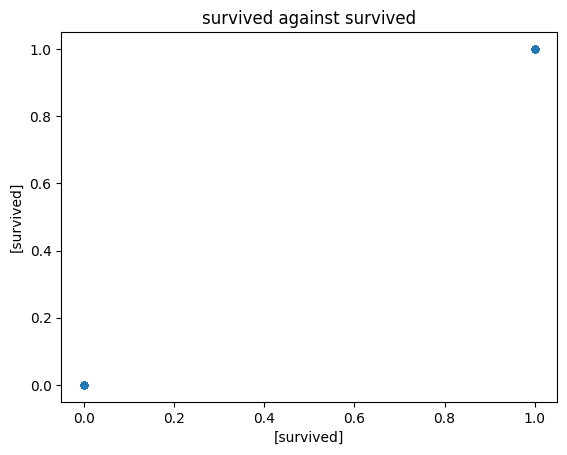

In [99]:
dataset.plot.scatter(x=[quantitative_vars[0]], y=y)
plt.title(f"{quantitative_vars[0]} against {y[0]}")
plt.show()

# Cross Validation Against other Models

In [75]:
transformed_dataset.head()

,continuous__survived,survived
0,-0.795343,0.0
1,-0.795343,0.0
2,-0.795343,0.0
3,1.257319,1.0
4,1.257319,1.0


In [76]:
# Define the scoring metrics
scoring = {
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

avg_scores = dict()

## Sklearn Classifiers


Average Scores:
Precision: 0.3739 (+/- 0.0316)
Recall: 0.6110 (+/- 0.0258)
Accuracy: 0.6110 (+/- 0.0258)
F1 Score: 0.4637 (+/- 0.0317)

Fold 1
Precision: 0.3665
Recall: 0.6054
Accuracy: 0.6054
F1 Score: 0.4566

Fold 2
Precision: 0.3346
Recall: 0.5785
Accuracy: 0.5785
F1 Score: 0.4240

Fold 3
Precision: 0.4170
Recall: 0.6457
Accuracy: 0.6457
F1 Score: 0.5067

Fold 4
Precision: 0.4034
Recall: 0.6351
Accuracy: 0.6351
F1 Score: 0.4934

Fold 5
Precision: 0.3482
Recall: 0.5901
Accuracy: 0.5901
F1 Score: 0.4380


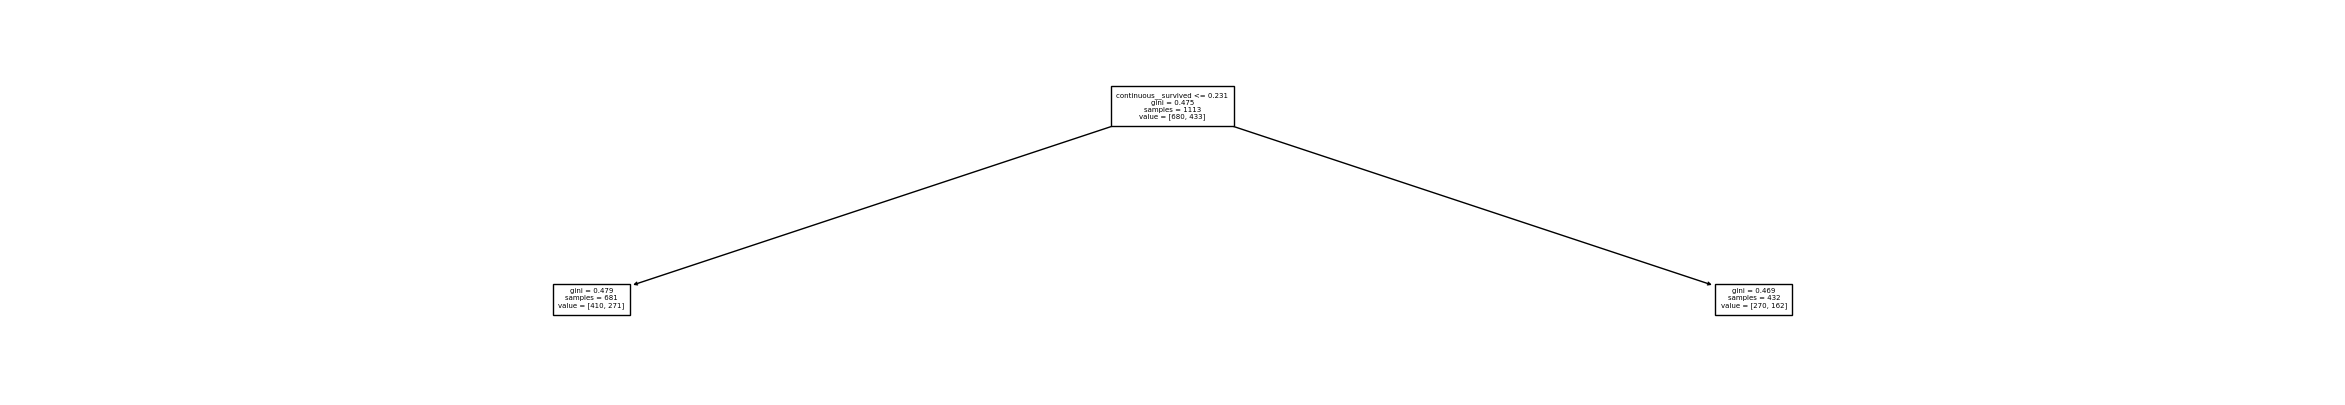

In [77]:
# Create a pipeline with preprocessor and DecisionTreeClassifier
pipeline = Pipeline([
    ('decision tree classifier', DecisionTreeClassifier())
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])

# Fit the pipeline to the data
pipeline.fit(transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])

# Create a figure and axis with a wider x-axis
fig, ax = plt.subplots(figsize=(30, 5))

# Plot the decision tree
sk.tree.plot_tree(pipeline.named_steps['decision tree classifier'],
                  max_depth=5,
                  feature_names=transformed_feature_names,
                  fontsize=5,
                  ax=ax)

plt.show()

In [78]:
# Create a pipeline with preprocessor and KNeighborsClassifier
pipeline = Pipeline([
    ('knn classifier', KNeighborsClassifier(n_neighbors=default_n_neighbors))
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.3079 (+/- 0.1824)
Recall: 0.4527 (+/- 0.0688)
Accuracy: 0.4527 (+/- 0.0688)
F1 Score: 0.3492 (+/- 0.1499)

Fold 1
Precision: 0.5186
Recall: 0.5291
Accuracy: 0.5291
F1 Score: 0.5227

Fold 2
Precision: 0.1777
Recall: 0.4215
Accuracy: 0.4215
F1 Score: 0.2500

Fold 3
Precision: 0.5420
Recall: 0.5381
Accuracy: 0.5381
F1 Score: 0.5400

Fold 4
Precision: 0.1331
Recall: 0.3649
Accuracy: 0.3649
F1 Score: 0.1951

Fold 5
Precision: 0.1680
Recall: 0.4099
Accuracy: 0.4099
F1 Score: 0.2384


In [79]:
# Create a pipeline with preprocessor and GaussianNB classifier
pipeline = Pipeline([
    ('gaussian naive bayes classifier', GaussianNB())
])


cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.3739 (+/- 0.0316)
Recall: 0.6110 (+/- 0.0258)
Accuracy: 0.6110 (+/- 0.0258)
F1 Score: 0.4637 (+/- 0.0317)

Fold 1
Precision: 0.3665
Recall: 0.6054
Accuracy: 0.6054
F1 Score: 0.4566

Fold 2
Precision: 0.3346
Recall: 0.5785
Accuracy: 0.5785
F1 Score: 0.4240

Fold 3
Precision: 0.4170
Recall: 0.6457
Accuracy: 0.6457
F1 Score: 0.5067

Fold 4
Precision: 0.4034
Recall: 0.6351
Accuracy: 0.6351
F1 Score: 0.4934

Fold 5
Precision: 0.3482
Recall: 0.5901
Accuracy: 0.5901
F1 Score: 0.4380


In [80]:
# Create a pipeline with preprocessor and SVM classifier
pipeline = Pipeline([
    ('svm classifier', SVM())
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.3739 (+/- 0.0316)
Recall: 0.6110 (+/- 0.0258)
Accuracy: 0.6110 (+/- 0.0258)
F1 Score: 0.4637 (+/- 0.0317)

Fold 1
Precision: 0.3665
Recall: 0.6054
Accuracy: 0.6054
F1 Score: 0.4566

Fold 2
Precision: 0.3346
Recall: 0.5785
Accuracy: 0.5785
F1 Score: 0.4240

Fold 3
Precision: 0.4170
Recall: 0.6457
Accuracy: 0.6457
F1 Score: 0.5067

Fold 4
Precision: 0.4034
Recall: 0.6351
Accuracy: 0.6351
F1 Score: 0.4934

Fold 5
Precision: 0.3482
Recall: 0.5901
Accuracy: 0.5901
F1 Score: 0.4380


In [81]:
# Create a pipeline with preprocessor and MLP classifier
pipeline = Pipeline([
    ('mlp classifier', MLP())
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.3739 (+/- 0.0316)
Recall: 0.6110 (+/- 0.0258)
Accuracy: 0.6110 (+/- 0.0258)
F1 Score: 0.4637 (+/- 0.0317)

Fold 1
Precision: 0.3665
Recall: 0.6054
Accuracy: 0.6054
F1 Score: 0.4566

Fold 2
Precision: 0.3346
Recall: 0.5785
Accuracy: 0.5785
F1 Score: 0.4240

Fold 3
Precision: 0.4170
Recall: 0.6457
Accuracy: 0.6457
F1 Score: 0.5067

Fold 4
Precision: 0.4034
Recall: 0.6351
Accuracy: 0.6351
F1 Score: 0.4934

Fold 5
Precision: 0.3482
Recall: 0.5901
Accuracy: 0.5901
F1 Score: 0.4380


In [82]:
# Create a pipeline with preprocessor and RandomForestClassifier classifier
pipeline = Pipeline([
    ('rf classifier', RandomForestClassifier())
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.3739 (+/- 0.0316)
Recall: 0.6110 (+/- 0.0258)
Accuracy: 0.6110 (+/- 0.0258)
F1 Score: 0.4637 (+/- 0.0317)

Fold 1
Precision: 0.3665
Recall: 0.6054
Accuracy: 0.6054
F1 Score: 0.4566

Fold 2
Precision: 0.3346
Recall: 0.5785
Accuracy: 0.5785
F1 Score: 0.4240

Fold 3
Precision: 0.4170
Recall: 0.6457
Accuracy: 0.6457
F1 Score: 0.5067

Fold 4
Precision: 0.4034
Recall: 0.6351
Accuracy: 0.6351
F1 Score: 0.4934

Fold 5
Precision: 0.3482
Recall: 0.5901
Accuracy: 0.5901
F1 Score: 0.4380


## Custom Approach

In [83]:
# Define the parameter grid
param_grid = {
    'regressor__n_neighbors': range(1, 5)
}

# Create a scorer dictionary
scorers = {
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

pipeline = Pipeline([
    ("regressor", PMFRegressor(max_bins_for_discretization))
])

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kf,  # Use the same KFold object as before
    scoring=scorers,
    refit='f1',  # Refit using the best F1 score
    return_train_score=False,
    n_jobs=-1  # Use all available cores
)

# Fit the GridSearchCV object
grid_search.fit(transformed_dataset[transformed_feature_names], transformed_dataset[y[0]].map(class_map))

# Get the results
results = pd.DataFrame(grid_search.cv_results_)

# Process the results
avg_scores["custom"] = dict()
f1_by_k = {}

for i, row in results.iterrows():
    k = row['param_regressor__n_neighbors']
    avg_scores["custom"][k] = {
        "precision": row['mean_test_precision'],
        "recall": row['mean_test_recall'],
        "accuracy": row['mean_test_accuracy'],
        "f1": row['mean_test_f1'],
        "std_precision": row['std_test_precision'],
        "std_recall": row['std_test_recall'],
        "std_accuracy": row['std_test_accuracy'],
        "std_f1": row['std_test_f1']
    }
    f1_by_k[k] = row['mean_test_f1']

# Convert f1_by_k to DataFrame
f1_by_k = pd.DataFrame(f1_by_k.items(), columns=["k", "f1"])

# Get the best parameters and scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_score}")

# You can now use the best model for predictions
best_model = grid_search.best_estimator_

X:
[[-0.79534311]
 [-0.79534311]
 [-0.79534311]
 [ 1.257319  ]
 [ 1.257319  ]]
y:
[0 0 0 1 1]
Best parameters: {'regressor__n_neighbors': 1}
Best F1 score: 0.46373770113989776


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.37394061 0.37394061        nan        nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.61096433 0.61096433        nan        nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [0.4637377 0.4637377       nan       nan]
  warnings.warn(


### Results

In [84]:
print(f1_by_k.head())

   k        f1
0  1  0.463738
1  2  0.463738
2  3       NaN
3  4       NaN


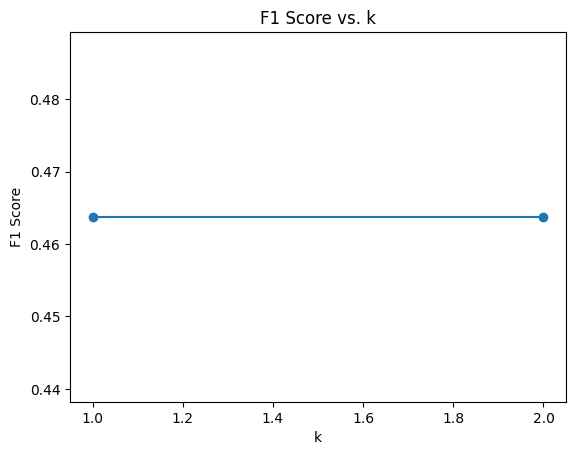

In [85]:
plt.plot(f1_by_k["k"], f1_by_k["f1"], marker='o') # Use plt.plot() for line plots
plt.title("F1 Score vs. k")
plt.xlabel("k")
plt.ylabel("F1 Score")
plt.show()

In [86]:
optimal_k = grid_search.best_params_['regressor__n_neighbors']

print(f"Optimal k: {optimal_k}")

Optimal k: 1


In [87]:
# Print average scores
print()
print("Average Scores for Optimal k:")
print(f"n_neighbors = {optimal_k}")
print(f"Precision: {avg_scores['custom'][optimal_k]['precision']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_precision']:.4f})")
print(f"Recall: {avg_scores['custom'][optimal_k]['recall']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_recall']:.4f})")
print(f"Accuracy: {avg_scores['custom'][optimal_k]['accuracy']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_accuracy']:.4f})")
print(f"F1 Score: {avg_scores['custom'][optimal_k]['f1']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_f1']:.4f})")


Average Scores for Optimal k:
n_neighbors = 1
Precision: 0.3739 (+/- 0.0316)
Recall: 0.6110 (+/- 0.0258)
Accuracy: 0.6110 (+/- 0.0258)
F1 Score: 0.4637 (+/- 0.0317)


In [88]:
model = best_model.fit(transformed_dataset[transformed_feature_names], transformed_dataset[y[0]].map(class_map))
y_pred = pd.Series(model.predict(transformed_dataset[transformed_feature_names]))

X:
[[-0.79534311]
 [-0.79534311]
 [-0.79534311]
 [ 1.257319  ]
 [ 1.257319  ]]
y:
[0 0 0 1 1]


In [89]:
transformed_feature_names

array(['continuous__survived'], dtype=object)

In [91]:
if len(quantitative_vars) > 1:
  plt.scatter(transformed_dataset["continuous__" + quantitative_vars[0]],\
              transformed_dataset["continuous__" + quantitative_vars[1]],\
              c=transformed_dataset[y[0]].map(colormap),\
              alpha=0.5)

  # Add labels and title
  plt.title("True Class")
  plt.xlabel(transformed_feature_names[0])
  plt.ylabel(transformed_feature_names[1])
  plt.yscale('log')
  plt.show()

  plt.scatter(transformed_dataset["continuous__" + quantitative_vars[0]],\
              transformed_dataset["continuous__" + quantitative_vars[1]],\
              c=y_pred.map(colormap),\
              alpha=0.5)

  # Add labels and title
  plt.title("Predicted Class")
  plt.xlabel(transformed_feature_names[0])
  plt.ylabel(transformed_feature_names[1])
  plt.yscale('log')
  plt.show()

## Compare Models

In [92]:
for model_name, scores in avg_scores.items():
      if model_name != "custom":
          print(f"{model_name}:")
          print(f"Precision: {scores['precision']:.4f} (+/- {scores['std_precision']:.4f})")
          print(f"Recall: {scores['recall']:.4f} (+/- {scores['std_recall']:.4f})")
          print(f"Accuracy: {scores['accuracy']:.4f} (+/- {scores['std_accuracy']:.4f})")
          print(f"F1 Score: {scores['f1']:.4f} (+/- {scores['std_f1']:.4f})")
          print()
      else:
          print(f"{model_name}:")
          print(f"Optimal n_neighbors = {optimal_k}")
          print(f"Precision: {avg_scores['custom'][optimal_k]['precision']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_precision']:.4f})")
          print(f"Recall: {avg_scores['custom'][optimal_k]['recall']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_recall']:.4f})")
          print(f"Accuracy: {avg_scores['custom'][optimal_k]['accuracy']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_accuracy']:.4f})")
          print(f"F1 Score: {avg_scores['custom'][optimal_k]['f1']:.4f} (+/- {avg_scores['custom'][optimal_k]['std_f1']:.4f})")
          print()

decision tree classifier:
Precision: 0.3739 (+/- 0.0316)
Recall: 0.6110 (+/- 0.0258)
Accuracy: 0.6110 (+/- 0.0258)
F1 Score: 0.4637 (+/- 0.0317)

knn classifier:
Precision: 0.3079 (+/- 0.1824)
Recall: 0.4527 (+/- 0.0688)
Accuracy: 0.4527 (+/- 0.0688)
F1 Score: 0.3492 (+/- 0.1499)

gaussian naive bayes classifier:
Precision: 0.3739 (+/- 0.0316)
Recall: 0.6110 (+/- 0.0258)
Accuracy: 0.6110 (+/- 0.0258)
F1 Score: 0.4637 (+/- 0.0317)

svm classifier:
Precision: 0.3739 (+/- 0.0316)
Recall: 0.6110 (+/- 0.0258)
Accuracy: 0.6110 (+/- 0.0258)
F1 Score: 0.4637 (+/- 0.0317)

mlp classifier:
Precision: 0.3739 (+/- 0.0316)
Recall: 0.6110 (+/- 0.0258)
Accuracy: 0.6110 (+/- 0.0258)
F1 Score: 0.4637 (+/- 0.0317)

rf classifier:
Precision: 0.3739 (+/- 0.0316)
Recall: 0.6110 (+/- 0.0258)
Accuracy: 0.6110 (+/- 0.0258)
F1 Score: 0.4637 (+/- 0.0317)

custom:
Optimal n_neighbors = 1
Precision: 0.3739 (+/- 0.0316)
Recall: 0.6110 (+/- 0.0258)
Accuracy: 0.6110 (+/- 0.0258)
F1 Score: 0.4637 (+/- 0.0317)



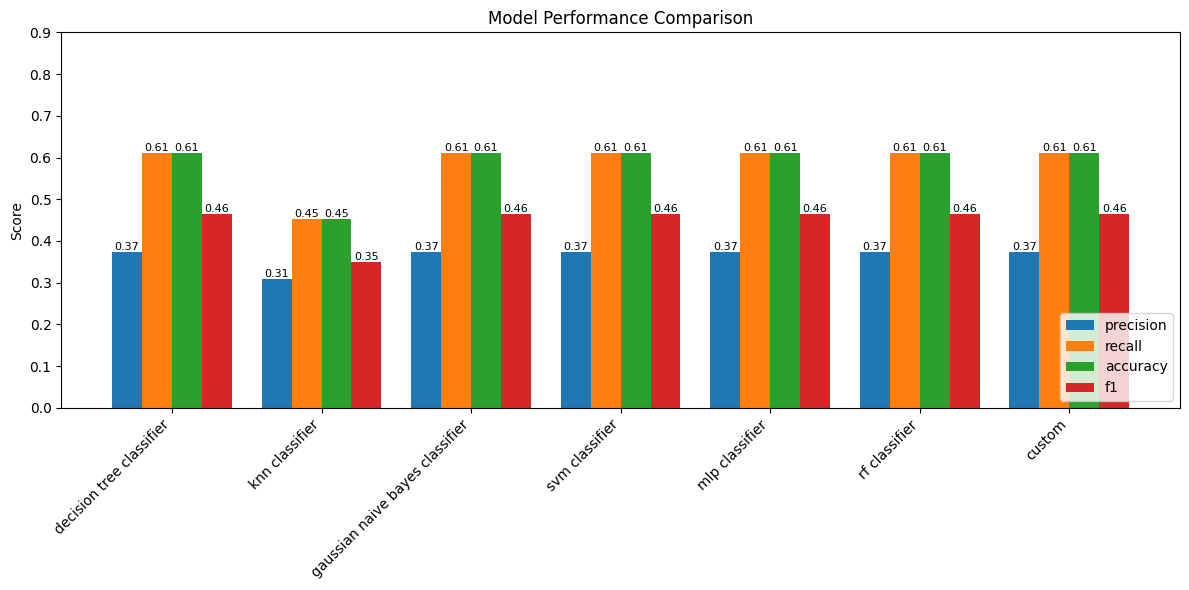

In [93]:
# Prepare data for plotting
models = list(avg_scores.keys())
metrics = ['precision', 'recall', 'accuracy', 'f1']
x = np.arange(len(models))
width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each metric
for i, metric in enumerate(metrics):
    values = []
    for model in models:
        if model == 'custom':
            values.append(avg_scores[model][optimal_k][metric])
        else:
            values.append(avg_scores[model][metric])
    ax.bar(x + i*width, values, width, label=metric)

# Customize the plot
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 0.9)

# Add value labels on top of each bar
for i, metric in enumerate(metrics):
    values = []
    for model in models:
        if model == 'custom':
            values.append(avg_scores[model][optimal_k][metric])
        else:
            values.append(avg_scores[model][metric])
    for j, v in enumerate(values):
        ax.text(j + i*width, v, f'{v:.2f}', ha='center', va='bottom', rotation=0, fontsize=8)

plt.tight_layout()
plt.show()